In [1]:
# coding: utf8

In [2]:
import os
import collections
import json
import string
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from itertools import chain
import numpy as np
import gc
from torchtext import data
from torchtext.data import Field, Example
import torchtext.vocab as vocab

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
train_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "train.txt")
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "test.txt")

In [6]:
data_list = []
entry = []
with open(train_path, 'r') as f:
  for line in f:
    if line is "\n":
      data_list.append(list(chain.from_iterable(entry)))
      entry = []
    else:
      entry.append(line.strip().split('\t'))

In [7]:
test_list = []
entry = []
with open(test_path, 'r') as f:
  for line in f:
    if line is "\n":
      test_list.append(list(chain.from_iterable(entry)))
      entry = []
    else:
      entry.append(line.strip().split('\t'))

In [9]:
data_list[0]

['巴林 公主 下 嫁 美 大兵 惊 世 婚姻 五 年 宣告 破裂',
 'bahraini princess marries us soldier , astonishing 5 year bond comes to end',
 'bahraini princess marries a u.s. soldier ; astounding marriage dissolves in 5 years',
 '0.3125',
 'H']

In [10]:
test_list[0]

['发言人 说 , 世人 共 知 , 中国 的 发展 不仅 符合 13 亿 中国人民 的 根本利益 , 也 有利于 世界 的 繁荣 与 发展 .',
 "the spokesman noted that it is known to all the world that china's development is not only in the fundamental interests of the 1.3 billion chinese people but also beneficial to the world's prosperity and development .",
 "the spokesman said , the world , a total of 13 million , not only conforms to the development of the people's interests , but also conducive to world prosperity and development .",
 '0.5100',
 'M']

In [8]:
train_df = pd.DataFrame(data_list, columns=['source', 'reference', 'target', 'score', 'label'])
test_df = pd.DataFrame(test_list, columns=['source', 'reference', 'target', 'score', 'label'])

In [9]:
train_df.loc[train_df.label == 'H', 'numLabel'] = 1
train_df.loc[train_df.label == 'M', 'numLabel'] = 0

In [56]:
test_df.loc[test_df.label == 'M', 'numLabel'] = 0
test_df.loc[test_df.label == 'H', 'numLabel'] = 1

In [65]:
test_df.sample(10)

,source,reference,target,score,label,numLabel
53,三峡 工程 地下 电站 即将 开工 建设,three gorges project's underground powerhouse ...,the three gorges project will begin constructi...,0.4545,M,0.0
69,郑和 是 世界 著名 航海家 .,zheng he is a world famous navigator .,a world renowned navigator zheng he .,0.7430,M,0.0
46,"托 莱 多 指出 , 尽管 安 共 体 内部 有 不少 问题 有待 解决 , 但 近年来 拉...",toledo pointed out that although many issues n...,"toledo noted that , despite the many problems ...",0.6727,H,1.0
97,"这 一 项目 与 国际 计划 中国 "" 供水 与 环境卫生 "" 项目 合作 后 , 将 推动...",its cooperation with plan international's chin...,this project and the international plan of the...,0.5330,M,0.0
54,"新华社 武汉 12 月 8 日 电 ( 记者 施 勇峰 ) 12 月 8 日 , 长江三峡 ...",xinhua news agency report of december 8th from...,"wuhan , december 8 ( xinhua ) two billion yuan...",0.3291,M,0.0
156,"2000 年 至 2002 年间 , 欧洲 吸 毒死 亡 人数 减少 了 20% .","between 2000 and 2002 , drug-related deaths in...","in 2000 and 2002 , the number of drug related ...",0.6111,H,1.0
168,"关 塔 那 摩 美国 海军基地 目前 关押 了 约 550 名 "" 基地 "" 组织 和 塔 ...","there are around 550 "" al-qaeda "" and taliban ...","currently , 550 suspected members of al-qaeda ...",0.4595,H,1.0
74,设计者 为 陕西省 西安 市 一 中学 美术 教师 姚 颖 .,"the designer is yao ying , a fine arts teacher...",the shaanxi provincial capital base of a secon...,0.3227,M,0.0
40,( 国际 ) 安 共 体 总统 理事会 在 秘鲁 举行 特别 会议,( international ) extraordinary summit of the ...,( international ) andean presidential council ...,0.6822,M,0.0
93,"11 月 上旬 , 科 政府 军 与 法国 驻 科 部队 发生 严重 冲突 后 , 科 局势...",the situation in the ivory coast further deter...,"in early november , a serious clash occurred b...",0.5938,H,1.0


### Bert Model pre-process


In [12]:
!pip install transformers

     |████████████████████████████████| 1.8MB 13.7MB/s 
     |████████████████████████████████| 890kB 50.4MB/s 
     |████████████████████████████████| 2.9MB 59.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b49e42a9a3c07c35f5ef84f0f1e00e0e7e2189016ac2774069668cdd8d7fd4dc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [13]:
import transformers
from transformers import BertModel, BertTokenizer

In [14]:
from tokenizers import BertWordPieceTokenizer
vocab_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert-base-uncased-vocab.txt")
tokenizer2 = BertWordPieceTokenizer(vocab_path, lowercase=True)

In [66]:
class MTDataset(Dataset):
    def __init__(self, source, reference, target, label, tokenizer, max_len):
        self.source = source
        self.reference = reference
        self.target = target
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):
        source = str(self.source[item])
        reference = str(self.reference[item])
        target = str(self.target[item])
        label = self.label[item]

        encoding = tokenizer.encode_plus(
            reference,
            target,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'source' : source,
            'reference' : reference,
            'target' : target,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'token_type_ids' : encoding['token_type_ids'].flatten(),
            'label': label,
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = MTDataset(
        source = df.source.to_numpy(),
        reference = df.reference.to_numpy(),
        target = df.target.to_numpy(),
        label = df.numLabel.to_numpy(),
        tokenizer = tokenizer,
        max_len= max_len,
    )

    return DataLoader(dataset, batch_size=batch_size)

In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [17]:
MAX_LEN = 512
BATCH_SIZE = 10
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
class MTBert(nn.Module):
    def __init__(self):
        super(MTBert, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.l1 = nn.Linear(self.bert.config.hidden_size, 1)
        self.loss = nn.CrossEntropyLoss(ignore_index=512)

    def compute_loss(self, pred_label, gold_label):
        return self.loss(pred_label, gold_label)

    def forward(self, input_ids, attention_mask, type_ids):
        outputs = self.bert(input_ids, attention_mask, type_ids)
        last_hidden_state = outputs.last_hidden_state
        label_output = self.l1(last_hidden_state)

        return label_output

In [19]:
def train(dataloader, model, optimizer, batch_size):
    model.train()
    epoch_loss = 0

    for item in dataloader:
        optimizer.zero_grad()
        input_ids = item['input_ids'].to(get_device())
        attention_mask = item['attention_mask'].to(get_device())
        token_type_ids = item['token_type_ids'].to(get_device())
        label = item['label'].to(get_device())
        
        if len(label) < 4:
          continue

        label_output = model(input_ids, attention_mask, token_type_ids)
        
        loss = model.compute_loss(label_output, torch.unsqueeze(label.long(), dim=-1))
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # break
    return epoch_loss

In [20]:
bert_mt = MTBert().to(get_device())
optimizer = torch.optim.AdamW(bert_mt.parameters(), lr=3e-5)

### Train Epoch

In [21]:
epoch = 5

for i in range(epoch):
  
  print(f'Epoch: {i}')
  train_loss = train(train_loader, bert_mt, optimizer, BATCH_SIZE)
  print(f'Train Loss {train_loss:.3f}')
  checkpt_name = 'bertMT_{}.p'.format(i)
  state = {'net': bert_mt.state_dict(), 'optimizer': optimizer.state_dict(),}
  torch.save(state, checkpt_name)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 0


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train Loss 109.362
Epoch: 1
Train Loss 22.612
Epoch: 2
Train Loss 9.804
Epoch: 3
Train Loss 6.008
Epoch: 4
Train Loss 1.737


###Validate using test.txt

In [43]:
def validate(model, dataloader, tokenizer):
    model.eval()
    counter = 0
    gold = []
    outputs = []
    for item in dataloader:
        input_ids = item['input_ids'].to(get_device())
        attention_mask = item['attention_mask'].to(get_device())
        token_type_ids = item['token_type_ids'].to(get_device())
        label_gold = item['label'].to(get_device())
        
        label_output = model(input_ids, attention_mask, token_type_ids)
        softmax_output = F.softmax(label_output, dim=1)
        

        label_answer = torch.argmax(softmax_output)
        # print(f'generated_answer: {label_answer}')
        gold.append(label_gold.cpu().numpy())
        outputs.append(label_answer.cpu().numpy())
        
        counter += 1

    return gold, outputs
        

In [67]:
val_loader = create_data_loader(test_df, tokenizer, MAX_LEN, 1)

In [68]:
gold_labels, output = validate(bert_mt, val_loader, tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [79]:
gold = list(chain.from_iterable(gold_labels))

In [80]:
preds = [int(x) for x in output]

### F-1 score and confusion matrix

In [48]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score

In [81]:
f1_score(gold, preds)

0.9411764705882353

In [51]:
!pip install plot-metric

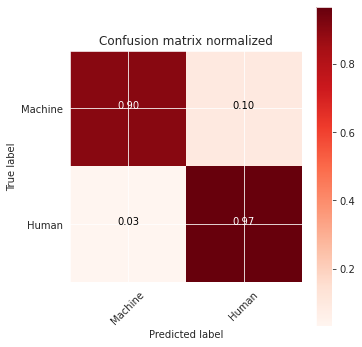

In [83]:
import matplotlib.pyplot as plt
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(gold, preds, labels=["Machine", "Human"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_confusion_matrix(normalize=True)
# bc.plot_roc_curve()
plt.show()